# Comparison of the Train time and Inference Time of `MNIST` MLP on CPUs 
# and GPUs with `keras`

### Jack Dinsmore
The purpose of this notebook is to determine the relative speeds of training `MNIST` on CPUs and GPUs, as well as the relative speeds of inference. It is a duplication of one of the experiments described in [this paper](https://arxiv.org/pdf/1904.08986.pdf) (arXiv:1904.08986v1 \[physics.data-an\]). Next, we will transform the code in this notebook into bare `tensorflow` code and compare runtime, set the GPU implementation up as a service, then transform the code again into a form that can be run on TPUs and perform a similar analysis.

The code for the implementations of mnist using MLP with `keras` were pulled from [this github](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

## Preparing the Dataset
We import all the necessary classes and set some of the globals for the program. `INFERENCE_NUM` is the number of trials we will make when computing the time per inference of the model for each batch size for each machine; we average all the trial times together at the end. `NUM_CLASSES` is the number of categories to train mnist on. `NUM_EPOCHS` describes the number of epochs to run training over. `BATCH_SIZES` is a list of sizes to over which compute runtimes, and it must be sorted from low to high in order for the graph to be made in the last step.

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import tensorflow as tf
from time import time
from random import random
import numpy as np

INFERENCE_NUM = 500
NUM_CLASSES=10
NUM_EPOCHS=5
BATCH_SIZES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

Using TensorFlow backend.


Now we download a dataset using keras and prepare it for training. This need only be done once.

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

60000 train samples
10000 test samples


Now we define a function to create a `keras` MNIST model. The machine will determine whether the model runs on GPUs or CPUs. The two options are `'/gpu:0'` and `'/cpu:0'`. We will run this function twice, first with CPUs, then with GPUs.

In [3]:
def create_model(machine):
    with tf.device(machine):
        model = Sequential()
        model.add(Dense(512, activation='relu', input_shape=(784,)))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(NUM_CLASSES, activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer=RMSprop(),
                      metrics=['accuracy'])
    return model

## Gathering Data
Now we create a function to train a model using a given batch size, then run some inferences and return the time to train the model and the time per inference. We will run this function once per machine type per batch size.

In [4]:
def get_times(batch_size):
    # Compute train time
    start_time = time()
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=NUM_EPOCHS,
                        verbose=1,
                        validation_data=(x_test, y_test))
    end_time = time()
    train_time = end_time - start_time
    
    score = model.evaluate(x_test, y_test, verbose=0)

    # Compute inference time
    inference_time = 0
    for i in range(INFERENCE_NUM): # Do multiple trials
        # Create batch_size inputs
        inputs = np.random.rand(batch_size, x_train.shape[1])
        
        #Time inference
        start_time = time()
        model.predict(inputs)
        end_time = time()
        inference_time += end_time - start_time
    inference_time /= INFERENCE_NUM
    
    return [train_time, inference_time / batch_size]

With this function, we get all the data we need for one machine: the train time and the time per inference for every batch size in `BATCH_SIZES`. It will return a list for train times and a list for run times so that the `n`th item of `BATCH_SIZES` will correspond to the `n`th item of `train_times` and `inference_times`. The other two return values are simply to make graphing the data later easier.

In [5]:
def get_plot():
    train_times = []
    inference_times = []
    max_train = 0
    max_inference = 0
    for size in BATCH_SIZES:
        train_time, inference_time = get_times(size)

        train_times.append(train_time)
        inference_times.append(inference_time)
        max_train = max(max_train, train_time)
        max_inference = max(max_inference, inference_time)

        print('\n','Batch size:', size, '\tTrain time:', train_time, '\tInference time', inference_time)
        print('+'*100)
    return train_times, inference_times, max_train, max_inference

Finally, we execute `get_plot` once for CPUs, and once for GPUs. The following code will generate all the data and will take the most time.

In [6]:
print("TRAIN ON CPUS")
print()
model = create_model('/cpu:0')
cpu_train_times, cpu_inference_times, max_train, max_inference = get_plot()

print()
print("TRAIN ON GPUS")
print()
print('+'*100)
model = create_model('/gpu:0')
gpu_train_times, gpu_inference_times, gpu_max_train, gpu_max_inference = get_plot()

print()
print("DONE")

max_train = max(max_train, gpu_max_train)
max_inference = max(max_inference, gpu_max_inference)

TRAIN ON CPUS

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 308s 5ms/step - loss: 0.7744 - acc: 0.9169 - val_loss: 0.6855 - val_acc: 0.9440
Epoch 2/5
60000/60000 [==============================] - 313s 5ms/step - loss: 0.6939 - acc: 0.9446 - val_loss: 0.5800 - val_acc: 0.9550
Epoch 3/5
60000/60000 [==============================] - 328s 5ms/step - loss: 0.5741 - acc: 0.9546 - val_loss: 0.4128 - val_acc: 0.9682
Epoch 4/5
60000/60000 [==============================] - 329s 5ms/step - loss: 0.5298 - acc: 0.9592 - val_loss: 0.3985 - val_acc: 0.9687
Epoch 5/5
60000/60000 [==============================] - 326s 5ms/step - loss: 0.4892 - acc: 0.9617 - val_loss: 0.3868 - val_acc: 0.9711

 Batch size: 1

60000/60000 [==============================] - 52s 863us/step - loss: 0.1450 - acc: 0.9884 - val_loss: 0.2337 - val_acc: 0.9808
Epoch 2/5
60000/60000 [==============================] - 56s 933us/step - loss: 0.1363 - acc: 0.9891 - val_loss: 0.2416 - val_acc: 0.9816
Epoch 3/5
60000/60000 [==============================] - 54s 900us/step - loss: 0.1365 - acc: 0.9893 - val_loss: 0.2383 - val_acc: 0.9817
Epoch 4/5
60000/60000 [==============================] - 52s 870us/step - loss: 0.1172 - acc: 0.9906 - val_loss: 0.2238 - val_acc: 0.9823
Epoch 5/5
60000/60000 [==============================] - 53s 888us/step - loss: 0.1193 - acc: 0.9905 - val_loss: 0.2331 - val_acc: 0.9823

 Batch size: 9 	Train time: 267.255779504776 	Inference time 0.00012929084565904404
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 52s 872us/step - loss: 0.12

60000/60000 [==============================] - 12s 192us/step - loss: 0.0525 - acc: 0.9955 - val_loss: 0.2059 - val_acc: 0.9827
Epoch 2/5
60000/60000 [==============================] - 12s 193us/step - loss: 0.0517 - acc: 0.9958 - val_loss: 0.2111 - val_acc: 0.9833
Epoch 3/5
60000/60000 [==============================] - 11s 192us/step - loss: 0.0523 - acc: 0.9957 - val_loss: 0.1970 - val_acc: 0.9842
Epoch 4/5
60000/60000 [==============================] - 12s 193us/step - loss: 0.0572 - acc: 0.9953 - val_loss: 0.2034 - val_acc: 0.9838
Epoch 5/5
60000/60000 [==============================] - 12s 194us/step - loss: 0.0519 - acc: 0.9956 - val_loss: 0.1920 - val_acc: 0.9842

 Batch size: 90 	Train time: 57.80539417266846 	Inference time 6.521679030524359e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 186us/step - loss: 0.0

60000/60000 [==============================] - 31s 521us/step - loss: 0.1453 - acc: 0.9884 - val_loss: 0.2392 - val_acc: 0.9818
Epoch 2/5
60000/60000 [==============================] - 31s 516us/step - loss: 0.1381 - acc: 0.9890 - val_loss: 0.2309 - val_acc: 0.9829
Epoch 3/5
60000/60000 [==============================] - 32s 536us/step - loss: 0.1369 - acc: 0.9892 - val_loss: 0.2287 - val_acc: 0.9827
Epoch 4/5
60000/60000 [==============================] - 31s 517us/step - loss: 0.1381 - acc: 0.9888 - val_loss: 0.2170 - val_acc: 0.9835
Epoch 5/5
60000/60000 [==============================] - 31s 516us/step - loss: 0.1267 - acc: 0.9896 - val_loss: 0.2301 - val_acc: 0.9824

 Batch size: 8 	Train time: 156.38233137130737 	Inference time 9.006369113922119e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 28s 472us/step - loss: 0.1

60000/60000 [==============================] - 3s 57us/step - loss: 0.0538 - acc: 0.9955 - val_loss: 0.2005 - val_acc: 0.9845
Epoch 2/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0572 - acc: 0.9954 - val_loss: 0.1955 - val_acc: 0.9848
Epoch 3/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0568 - acc: 0.9953 - val_loss: 0.2070 - val_acc: 0.9837
Epoch 4/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0510 - acc: 0.9960 - val_loss: 0.1954 - val_acc: 0.9847
Epoch 5/5
60000/60000 [==============================] - 4s 61us/step - loss: 0.0545 - acc: 0.9955 - val_loss: 0.2094 - val_acc: 0.9832

 Batch size: 80 	Train time: 17.325928926467896 	Inference time 2.8447258472442628e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 54us/step - loss: 0.0552 - acc:

## Plotting the Data
Now we wish to compare train time and inference time between CPUs and GPUs. We will make two plots, one for train time and one for inference time. First, we import the required modules.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

Then we trainsfer the data we've collected into `numpy` arrays for use in `matplotlib`, and change the units on the inference graph vertical axis to be more appropriate.

In [8]:
UNITS = 's ms us ns'.split()
unit_index = 0

while max_inference < 1:
    for i in range(len(cpu_inference_times)):
        cpu_inference_times[i] *= 1000
        gpu_inference_times[i] *= 1000
    max_inference *= 1000
    unit_index += 1
if unit_index >= len(UNITS):
    raise RuntimeError('Your inference times ('+str(max_inference / 1000**unit_index)+') are unreasonably small.')
    
x = np.array(BATCH_SIZES)
cpu_train_times = np.array(cpu_train_times)
cpu_inference_times = np.array(cpu_inference_times)
gpu_train_times = np.array(gpu_train_times)
gpu_inference_times = np.array(gpu_inference_times)

Plot the train time as a function of batch size.

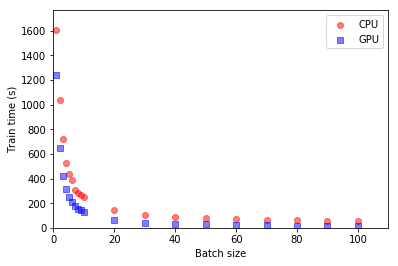

In [9]:
plt.scatter(x, cpu_train_times, c='r', alpha = 0.5)
plt.scatter(x, gpu_train_times, c='b', alpha = 0.5, marker='s')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.legend(['CPU', 'GPU'])
plt.axis([0, BATCH_SIZES[-1]*1.1, 0, max_train*1.1])
plt.show()

Plot the time per inference as a function of batch size.

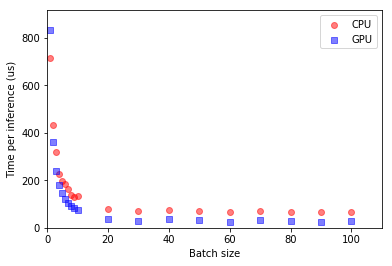

In [10]:
plt.scatter(x, cpu_inference_times, c='r', alpha = 0.5)
plt.scatter(x, gpu_inference_times, c='b', alpha = 0.5, marker='s')
plt.xlabel('Batch size')
plt.ylabel('Time per inference ('+UNITS[unit_index]+')')
plt.legend(['CPU', 'GPU'])
plt.axis([0, BATCH_SIZES[-1]*1.1, 0, max_inference*1.1])
plt.show()

We can also make a couple other plots, such as the performance gain in using gpus over cpus:

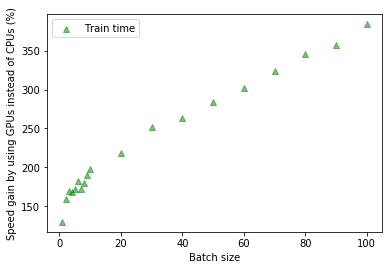

In [24]:
gain_train = []
for i in range(cpu_train_times.shape[0]):
    gain_train.append(cpu_train_times[i] / gpu_train_times[i] * 100)
gain_train = np.array(gain_train)

gain_inference = []
for i in range(cpu_inference_times.shape[0]):
    gain_inference.append(cpu_inference_times[i] / gpu_inference_times[i] * 100)
gain_inference = np.array(gain_inference)

plt.scatter(x, gain_train, c='g', alpha = 0.5, marker = '^')
plt.xlabel('Batch size')
plt.ylabel('Speed gain by using GPUs instead of CPUs (%)')
plt.legend(['Train time', 'Inference time'])
plt.show()

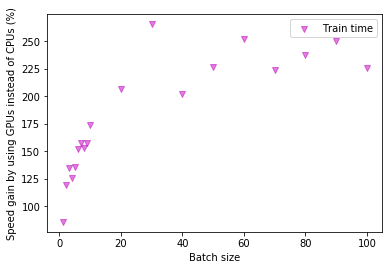

In [25]:
plt.scatter(x, gain_inference, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Speed gain by using GPUs instead of CPUs (%)')
plt.legend(['Train time', 'Inference time'])
plt.show()

The collection of the above data concludes this experiment.